In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import tensorflow as tf
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

## A. Dataset

###A.1 Import Data

In [ ]:
df = pd.read_csv('/content/Data_Tanaman_Padi_Sumatera_version_1.csv')
df_copy = df.copy()
df

,Provinsi,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
0,Aceh,1993,1329536.00,323589.00,1627.0,82.00,26.06
1,Aceh,1994,1299699.00,329041.00,1521.0,82.12,26.92
2,Aceh,1995,1382905.00,339253.00,1476.0,82.72,26.27
3,Aceh,1996,1419128.00,348223.00,1557.0,83.00,26.08
4,Aceh,1997,1368074.00,337561.00,1339.0,82.46,26.31
...,...,...,...,...,...,...,...
219,Lampung,2016,3831923.00,390799.00,2317.6,79.40,26.45
220,Lampung,2017,4090654.00,396559.00,1825.1,77.04,26.36
221,Lampung,2018,2488641.91,511940.93,1385.8,76.05,25.50
222,Lampung,2019,2164089.33,464103.42,1706.4,78.03,27.23


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Provinsi        224 non-null    object 
 1   Tahun           224 non-null    int64  
 2   Produksi        224 non-null    float64
 3   Luas Panen      224 non-null    float64
 4   Curah hujan     224 non-null    float64
 5   Kelembapan      224 non-null    float64
 6   Suhu rata-rata  224 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.4+ KB


In [ ]:
df.describe()

,Tahun,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
count,224.000000,2.240000e+02,224.000000,224.000000,224.000000,224.000000
mean,2006.500000,1.679701e+06,374349.966920,2452.490759,80.948705,26.801964
std,8.095838,1.161387e+06,232751.161987,1031.972625,4.878680,1.197041
min,1993.000000,4.293800e+04,63142.040000,222.500000,54.200000,22.190000
25%,1999.750000,5.488570e+05,146919.500000,1703.525000,78.975000,26.177500
50%,2006.500000,1.667773e+06,373551.500000,2315.700000,82.375000,26.730000
75%,2013.250000,2.436851e+06,514570.250000,3039.700000,84.000000,27.200000
max,2020.000000,4.881089e+06,872737.000000,5522.000000,90.600000,29.850000


In [ ]:
df.iloc[:,3:].corr()

,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
Luas Panen,1.000000,-0.092975,-0.061121,0.115726
Curah hujan,-0.092975,1.000000,0.056466,-0.228699
Kelembapan,-0.061121,0.056466,1.000000,-0.407799
Suhu rata-rata,0.115726,-0.228699,-0.407799,1.000000


### A.2 EDA

##### **Insight 1: Trend of Rice Production Over the Years in Sumatra**

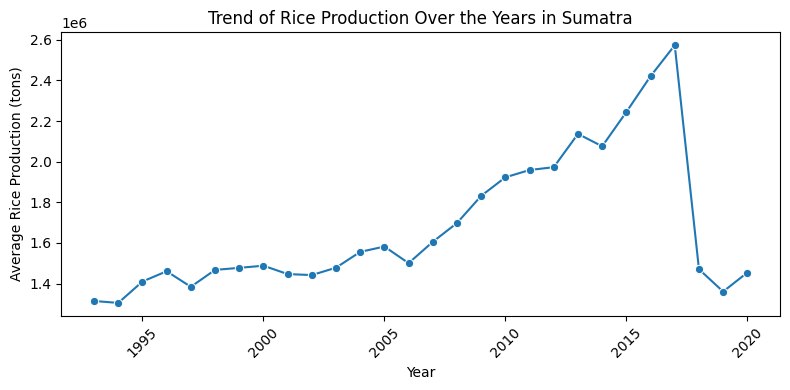

In [ ]:
plt.figure(figsize=(8, 4))
sns.lineplot(x='Tahun', y='Produksi', data=df, estimator='mean', errorbar=None, marker='o')
plt.title('Trend of Rice Production Over the Years in Sumatra')
plt.xlabel('Year')
plt.ylabel('Average Rice Production (tons)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Grafik garis menunjukkan perubahan rata-rata produksi beras dari waktu ke waktu. Kami mengamati adanya peningkatan secara umum, yang menunjukkan keberhasilan sektor pertanian dalam hal produksi beras. Peningkatan ini menunjukkan bahwa seiring berjalannya waktu, terlepas dari fluktuasi tahunannya, Sumatera telah mampu meningkatkan produksi berasnya. Namun, grafik tersebut juga menunjukkan periode stabil dan sedikit penurunan, yang mungkin berhubungan dengan kejadian cuaca buruk, faktor ekonomi, atau tantangan regional lainnya.

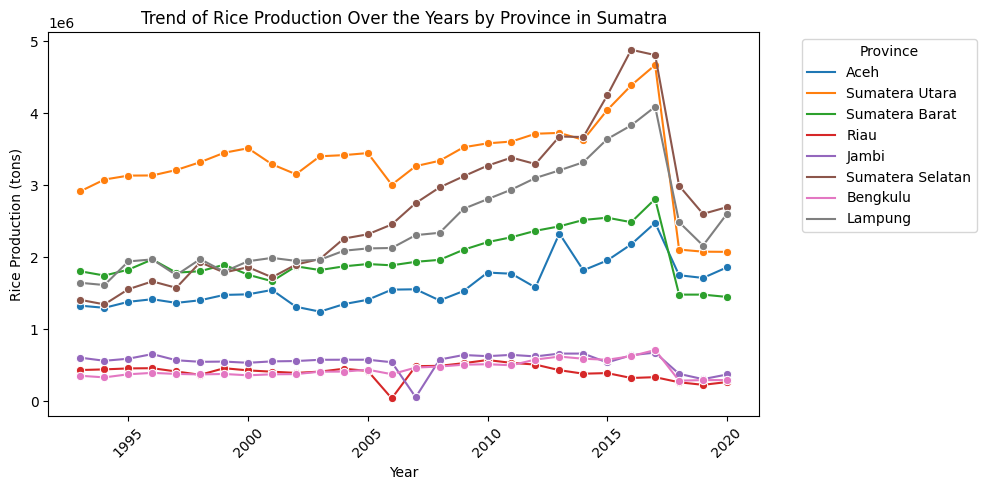

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='Tahun', y='Produksi', hue='Provinsi', data=df, marker='o')
plt.title('Trend of Rice Production Over the Years by Province in Sumatra')
plt.xlabel('Year')
plt.ylabel('Rice Production (tons)')
plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Visualisasi ini diperluas dengan mengelompokkan tren produksi berdasarkan provinsi. Hal ini memungkinkan kita untuk membandingkan kinerja masing-masing provinsi secara individual. Beberapa provinsi menunjukkan peningkatan produksi yang kuat dan stabil, sementara provinsi lainnya lebih bervariasi. Keragaman tren tersebut menunjukkan bahwa faktor regional memainkan peran penting dalam produksi beras, dan data dari provinsi-provinsi dengan kinerja tinggi dapat memberikan wawasan mengenai praktik pertanian yang efektif.

##### **Insight 2: Which province has the highest average rice production?**

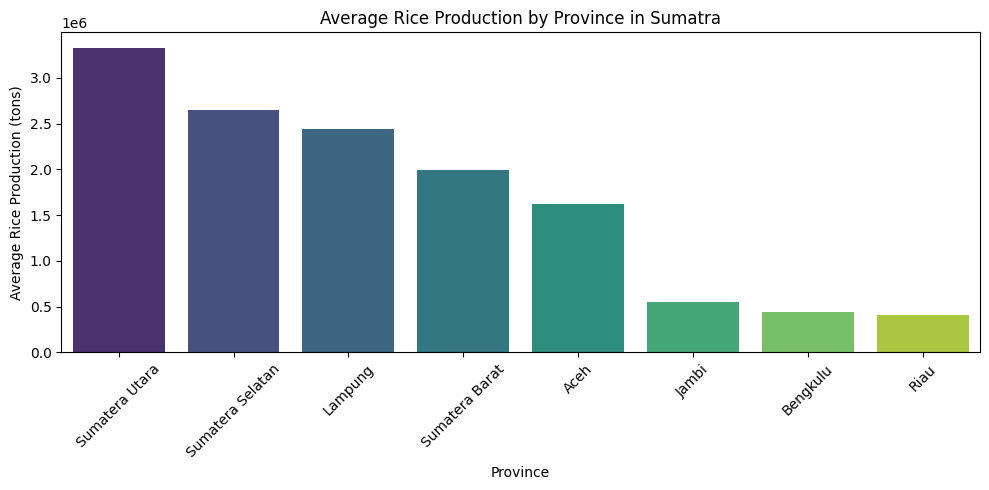

In [ ]:
plt.figure(figsize=(10, 5))
average_production_by_province = df.groupby('Provinsi')['Produksi'].mean().sort_values(ascending=False)
sns.barplot(x=average_production_by_province.index, y=average_production_by_province.values, palette="viridis")
plt.title('Average Rice Production by Province in Sumatra')
plt.xlabel('Province')
plt.ylabel('Average Rice Production (tons)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Provinsi di sebelah kiri, dengan batang yang lebih tinggi, merupakan produsen utama, hal ini menunjukkan bahwa provinsi tersebut memiliki kondisi atau praktik pertanian padi yang optimal. Sebaliknya, provinsi-provinsi di sebelah kanan, dengan batasan yang lebih pendek, mempunyai produksi yang lebih rendah, dan wilayah-wilayah ini dapat menjadi sasaran pengembangan pertanian.

##### **Insight 3: How does the average yield (production per hectare) vary by province?**

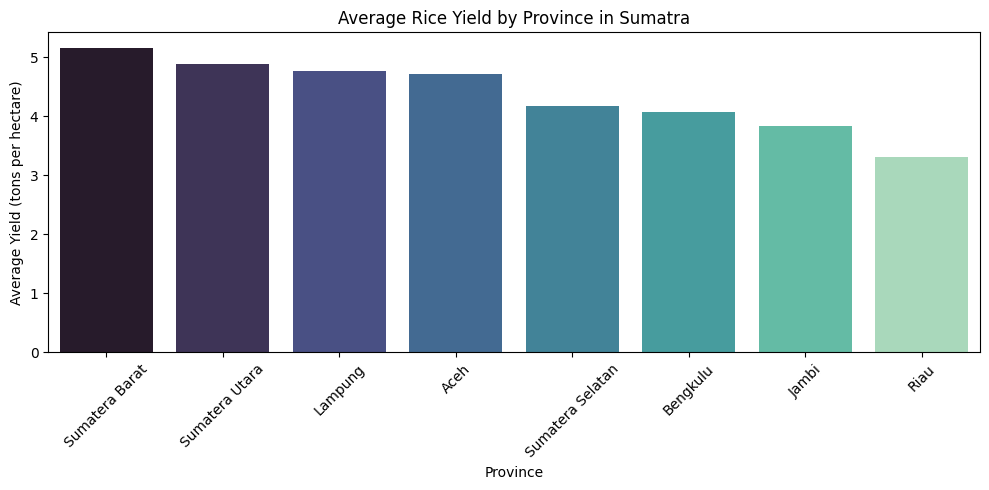

In [ ]:
df['Yield'] = df['Produksi'] / df['Luas Panen']

plt.figure(figsize=(10, 5))
average_yield_by_province = df.groupby('Provinsi')['Yield'].mean().sort_values(ascending=False)
sns.barplot(x=average_yield_by_province.index, y=average_yield_by_province.values, palette="mako")
plt.title('Average Rice Yield by Province in Sumatra')
plt.xlabel('Province')
plt.ylabel('Average Yield (tons per hectare)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Diagram batang menyajikan rata-rata hasil panen padi di setiap provinsi, dan hasil panen didefinisikan sebagai produksi per hektar. Langkah ini penting karena menunjukkan efisiensi lahan yang digunakan untuk budidaya padi. Visualisasi tersebut menunjukkan provinsi mana yang memiliki sawah paling produktif, menyoroti provinsi yang menghasilkan hasil lebih tinggi dengan lahan lebih sedikit. Provinsi di sebelah kiri grafik, dengan garis yang lebih tinggi, lebih efisien, mungkin karena kualitas tanah, teknik pertanian, atau faktor menguntungkan lainnya yang lebih baik. Sebaliknya, provinsi di sebelah kanan, dengan batasan yang lebih rendah, mungkin memiliki peluang untuk meningkatkan praktik pertanian atau mungkin menghadapi kendala lingkungan. Wawasan ini sangat penting untuk memahami seberapa efektif lahan tersebut digunakan untuk produksi padi dan dapat memberikan masukan bagi strategi untuk meningkatkan hasil padi di seluruh Sumatera.

##### **Insight 4: Relationship of Rice Production with Harvested Area, Rainfall, Humidity, and Average Temperature in Sumatra**

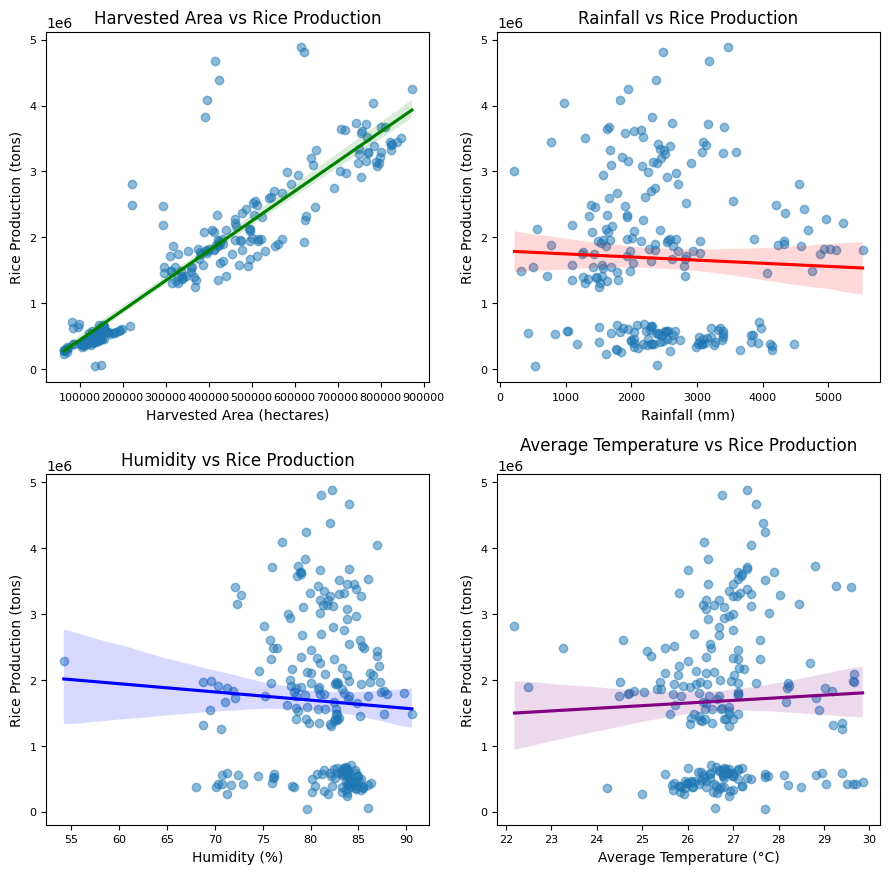

In [ ]:
# Modifying the subplot arrangement to 2x2 for better visualization

fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Relationship between harvested area and rice production
sns.regplot(ax=axes[0, 0], x=df['Luas Panen'], y=df['Produksi'], scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
axes[0, 0].set_title('Harvested Area vs Rice Production')
axes[0, 0].set_xlabel('Harvested Area (hectares)')
axes[0, 0].set_ylabel('Rice Production (tons)')
axes[0, 0].tick_params(labelsize=8)

# Relationship between rainfall and rice production
sns.regplot(ax=axes[0, 1], x='Curah hujan', y='Produksi', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 1].set_title('Rainfall vs Rice Production')
axes[0, 1].set_xlabel('Rainfall (mm)')
axes[0, 1].set_ylabel('Rice Production (tons)')
axes[0, 1].tick_params(labelsize=8)

# Relationship between humidity and rice production
sns.regplot(ax=axes[1, 0], x=df['Kelembapan'], y=df['Produksi'], scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
axes[1, 0].set_title('Humidity vs Rice Production')
axes[1, 0].set_xlabel('Humidity (%)')
axes[1, 0].set_ylabel('Rice Production (tons)')
axes[1, 0].tick_params(labelsize=8)

# Relationship between average temperature and rice production
sns.regplot(ax=axes[1, 1], x=df['Suhu rata-rata'], y=df['Produksi'], scatter_kws={'alpha':0.5}, line_kws={'color':'purple'})
axes[1, 1].set_title('Average Temperature vs Rice Production')
axes[1, 1].set_xlabel('Average Temperature (°C)')
axes[1, 1].set_ylabel('Rice Production (tons)')
axes[1, 1].tick_params(labelsize=8)

plt.tight_layout()
plt.show()


Gabungan visualisasi tersebut kini mencakup hubungan antara curah hujan dan produksi padi serta faktor-faktor yang telah dibahas sebelumnya:
- Luas Panen dan Produksi Padi: Korelasi positif antara luas panen dan produksi menunjukkan bahwa peningkatan luas tanam padi dapat meningkatkan produksi secara keseluruhan.
- Curah Hujan dan Produksi Beras: Penambahan plot hubungan curah hujan memperkuat korelasi positif antara curah hujan dan produksi beras, yang menunjukkan bahwa pasokan air yang cukup dari curah hujan bermanfaat bagi hasil panen padi.
- Kelembapan dan Produksi Beras: Keberagaman dalam hubungan antara kelembapan dan produksi menunjukkan bahwa kelembapan saja bukan merupakan prediktor yang kuat terhadap tingkat produksi, kemungkinan besar disebabkan oleh kemampuan adaptasi beras terhadap tingkat kelembapan yang berbeda.
- Suhu Rata-rata dan Produksi Beras: Hubungan antara suhu dan produksi nampaknya lemah, hal ini menunjukkan bahwa dalam kisaran suhu yang diamati, produksi beras tidak terlalu sensitif terhadap variasi suhu di Sumatera.

Secara keseluruhan, visualisasi ini memberikan gambaran komprehensif tentang bagaimana berbagai faktor lingkungan berkorelasi dengan produksi padi di Sumatera. Curah hujan yang cukup dan lahan pertanian yang cukup tampaknya menjadi faktor kunci dalam memaksimalkan hasil panen padi, sementara kelembapan dan suhu dalam kisaran normal di wilayah tersebut mempunyai pengaruh yang kurang jelas. Wawasan ini dapat menjadi masukan bagi kebijakan pertanian yang berfokus pada pengelolaan air, penggunaan lahan, dan strategi adaptasi iklim.

## B. Analisis Forecasting

### B.1 Preprocessing

In [ ]:
df_copy.set_index("Tahun", inplace=True)
df_copy.head()

,Provinsi,Produksi,Luas Panen,Curah hujan,Kelembapan,Suhu rata-rata
Tahun,,,,,,
1993,Aceh,1329536.0,323589.0,1627.0,82.00,26.06
1994,Aceh,1299699.0,329041.0,1521.0,82.12,26.92
1995,Aceh,1382905.0,339253.0,1476.0,82.72,26.27
1996,Aceh,1419128.0,348223.0,1557.0,83.00,26.08
1997,Aceh,1368074.0,337561.0,1339.0,82.46,26.31


In [ ]:
df_copy['Provinsi'].unique()

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung'], dtype=object)

In [ ]:
# Fungsi Konversi ke timeseries
def prepare_data_for_lstm(df, province, n_past=3, n_future=1, test_size=7, drop_columns=['Provinsi']):
    # Filter and split the dataset
    province_df = df[df['Provinsi'] == province]
    if drop_columns:
        province_df = province_df.drop(columns=drop_columns)
    df_train = province_df[:-test_size]
    df_test = province_df[-test_size - n_past:]

    scaler = MinMaxScaler()
    columns = (['Produksi', 'Luas Panen', 'Curah hujan', 'Kelembapan', 'Suhu rata-rata'])
    df_train = scaler.fit_transform(df_train)
    df_test = scaler.transform(df_test)

    # Prepare training and testing sequences
    df_train = np.array(df_train)
    df_test = np.array(df_test)
    X, y = [], []
    for i in range(n_past, len(df_train) - n_future+1):
      X.append(df_train[i - n_past:i, 1:df_train.shape[1]])
      y.append(df_train[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X), np.array(y)

    X, y = [], []
    for i in range(n_past, len(df_test) - n_future+1):
      X.append(df_test[i - n_past:i, 1:df_test.shape[1]])
      y.append(df_test[i + n_future - 1:i + n_future, 0])
    X_test, y_test = np.array(X), np.array(y)

    return X_train, y_train, X_test, y_test

### B.2 Konfigurasi Model

In [ ]:
def create_lstm_model(X_train, y_train, epoch):
    tf.random.set_seed(42)
    np.random.seed(42)
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

    history = model.fit(X_train, y_train, epochs=epoch, validation_split=0.1, verbose=0, callbacks=[TqdmCallback(verbose=1)])

    return model, history

### B.3 Implementasi

###### **1.Aceh**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Aceh', n_past=3, n_future=1, test_size=7,)
model1, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

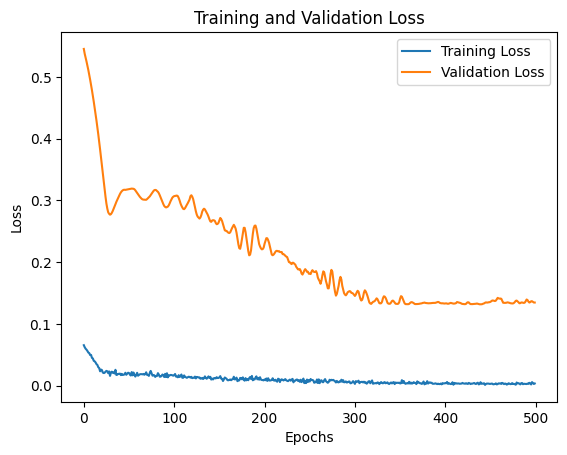

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model1.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 27ms/step - loss: 0.2655 - root_mean_squared_error: 0.5153


[0.2655062675476074, 0.5152730345726013]

In [ ]:
test_predictions = model1.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 993ms/step


,Train Predictions,Actual
0,0.992078,0.528800
1,1.254764,0.655021
2,1.609769,0.861409
3,1.363338,1.136363
4,0.877196,0.466035
5,0.009966,0.431400
6,-0.003895,0.567074


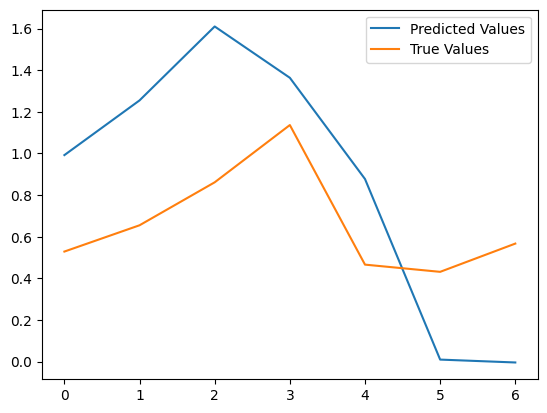

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.51527


###### **2.Sumatera Utara**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Sumatera Utara', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, 500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

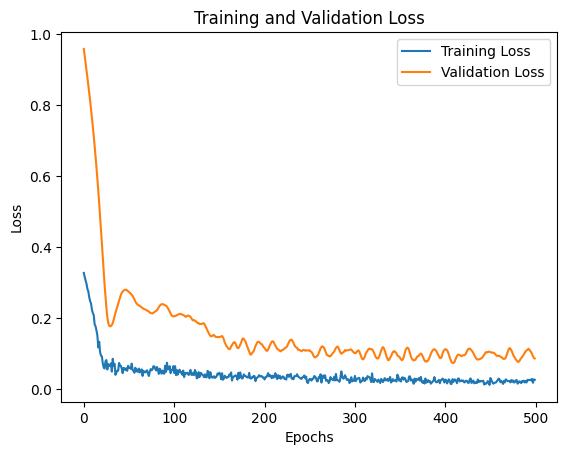

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 28ms/step - loss: 2.7013 - root_mean_squared_error: 1.6436


[2.701310873031616, 1.6435664892196655]

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 976ms/step


,Train Predictions,Actual
0,0.766061,0.881090
1,0.816143,1.392512
2,0.848420,1.815461
3,0.871158,2.164914
4,1.011249,-1.000952
5,1.405939,-1.037268
6,1.395998,-1.040508


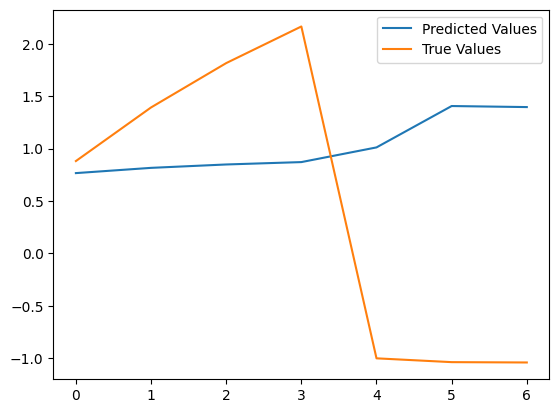

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 1.64357


###### **3.Sumatera Barat**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Sumatera Barat', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 29ms/step - loss: 0.2411 - root_mean_squared_error: 0.4910


[0.24111029505729675, 0.49102982878685]

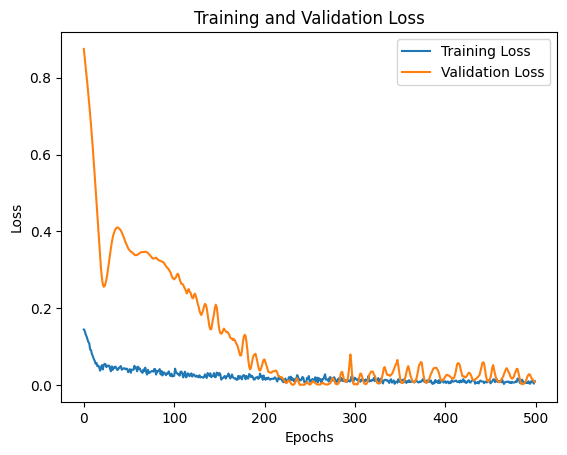

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 986ms/step


,Train Predictions,Actual
0,1.073485,1.116407
1,1.455927,1.157894
2,1.494385,1.075575
3,1.113970,1.499115
4,0.248134,-0.244118
5,0.462696,-0.244224
6,0.442462,-0.286455


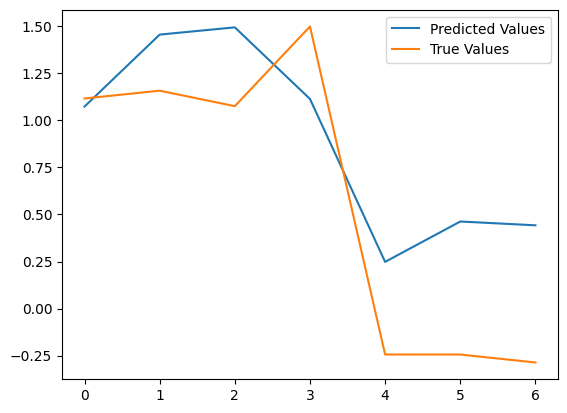

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.49103


###### **4.Riau**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Riau', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, 500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

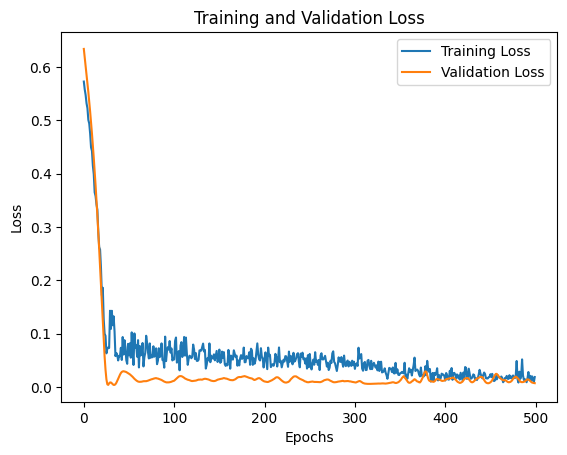

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 985ms/step


,Train Predictions,Actual
0,0.792571,0.643956
1,0.740588,0.659827
2,0.656283,0.531818
3,0.585064,0.553616
4,0.544876,0.420054
5,0.406223,0.353312
6,0.386056,0.425634


In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 28ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964


[0.009290863759815693, 0.09638912230730057]

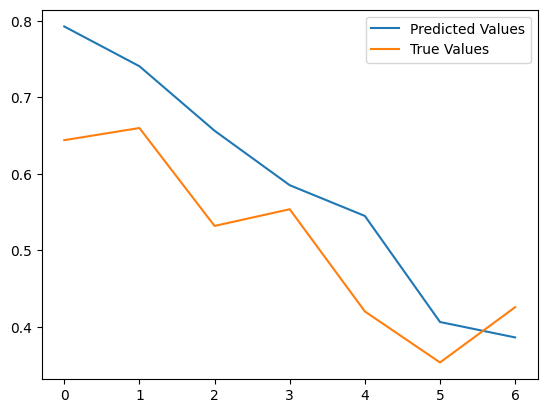

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.09639


###### **5.Jambi**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Jambi', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

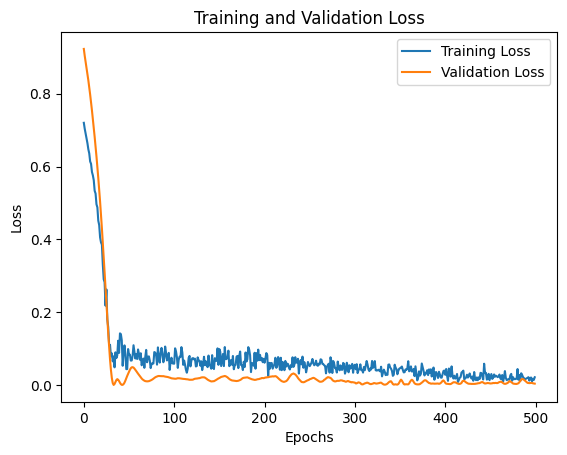

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 28ms/step - loss: 0.1024 - root_mean_squared_error: 0.3201


[0.10244660824537277, 0.32007282972335815]

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 972ms/step


,Train Predictions,Actual
0,0.889560,1.000305
1,0.888050,0.796906
2,0.869832,0.962962
3,0.852540,1.022434
4,0.908647,0.535398
5,0.969917,0.414724
6,0.980940,0.521089


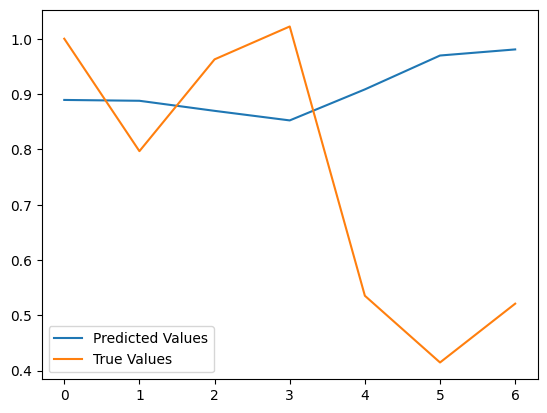

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.32007


###### **6.Sumatera Selatan**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Sumatera Selatan', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

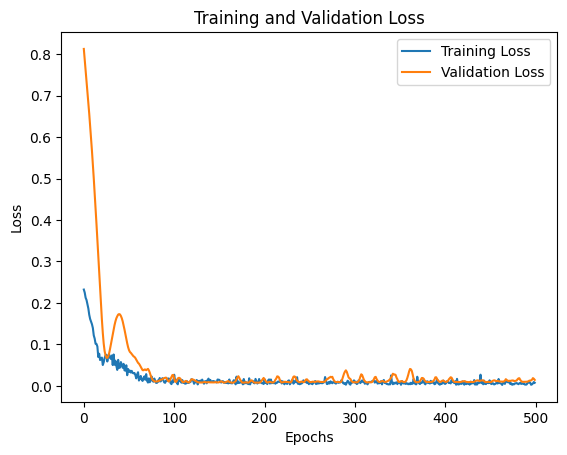

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 37ms/step - loss: 0.0583 - root_mean_squared_error: 0.2414


[0.05828535184264183, 0.2414235919713974]

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 1s/step


,Train Predictions,Actual
0,1.111474,0.997300
1,1.026358,1.245243
2,1.188363,1.517092
3,1.389638,1.485467
4,1.097156,0.706956
5,0.326530,0.539169
6,0.399488,0.579305


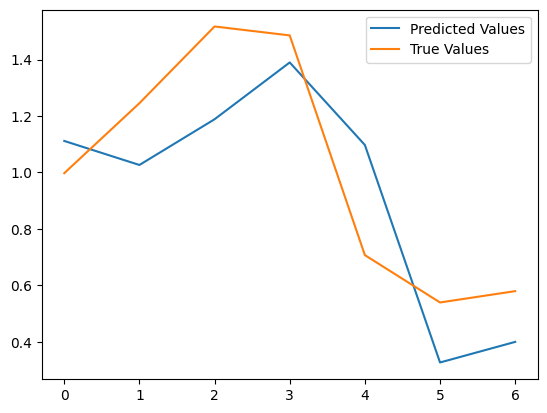

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.24142


###### **7.Bengkulu**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Bengkulu', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

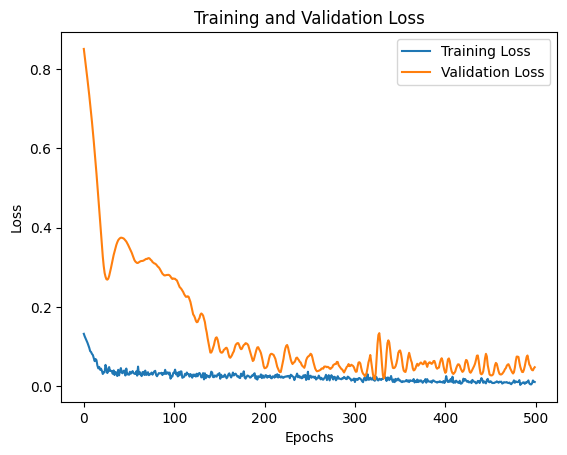

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 28ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961


[0.246067613363266, 0.4960520267486572]

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 985ms/step


,Train Predictions,Actual
0,1.239768,0.897304
1,1.071733,0.846923
2,0.830413,1.022148
3,0.190364,1.315956
4,0.140304,-0.157386
5,0.156241,-0.130838
6,0.153396,-0.129268


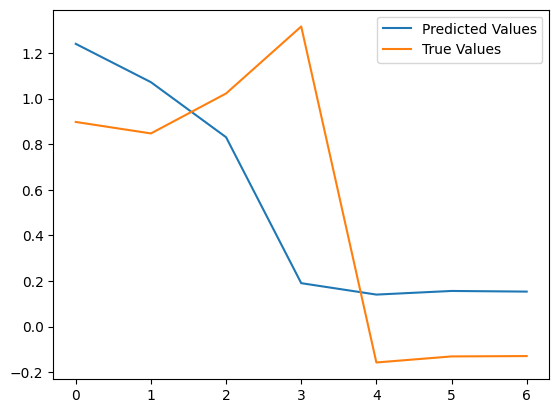

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.49605


###### **8.Lampung**

In [ ]:
X_train_aceh, y_train_aceh, X_test_aceh, y_test_aceh = prepare_data_for_lstm(df_copy, 'Lampung', n_past=3, n_future=1, test_size=7,)
model, history = create_lstm_model(X_train_aceh, y_train_aceh, epoch=500)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

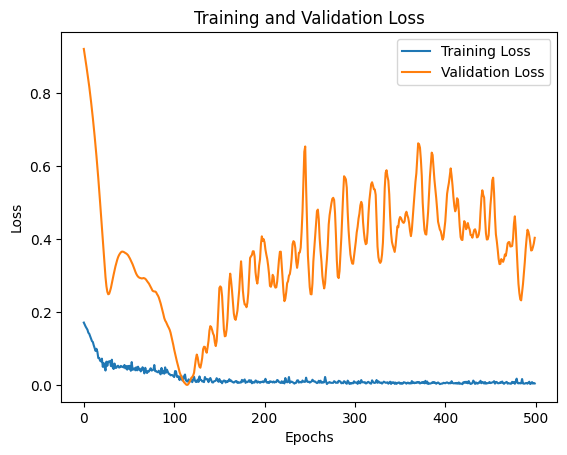

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test_aceh, y_test_aceh)

1/1 [==============================] - 0s 28ms/step - loss: 0.6725 - root_mean_squared_error: 0.8201


[0.6725180745124817, 0.8200719952583313]

In [ ]:
test_predictions = model.predict(X_test_aceh).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test_aceh.flatten()})
test_results

1/1 [==============================] - 1s 1s/step


,Train Predictions,Actual
0,2.147723,1.071052
1,2.348764,1.273303
2,2.386706,1.392723
3,2.368381,1.555319
4,1.257209,0.548556
5,0.189423,0.344596
6,0.156384,0.621626


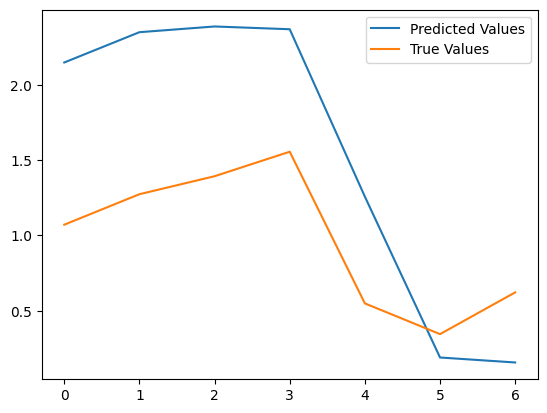

In [ ]:
plt.plot(test_results['Train Predictions'][:10], label='Predicted Values')
plt.plot(test_results['Actual'][:10], label='True Values')
plt.legend()
plt.show()

In [ ]:
rmse = sqrt(mse(y_test_aceh, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.82007
